In [1]:
# pip install ipympl
%matplotlib widget
from logparser import get_events_from
from plotter import plot_gc, plot_membalancer_heap_rule
from GarbageCollector import MemBalancer
import numpy as np
import matplotlib.pyplot as plt

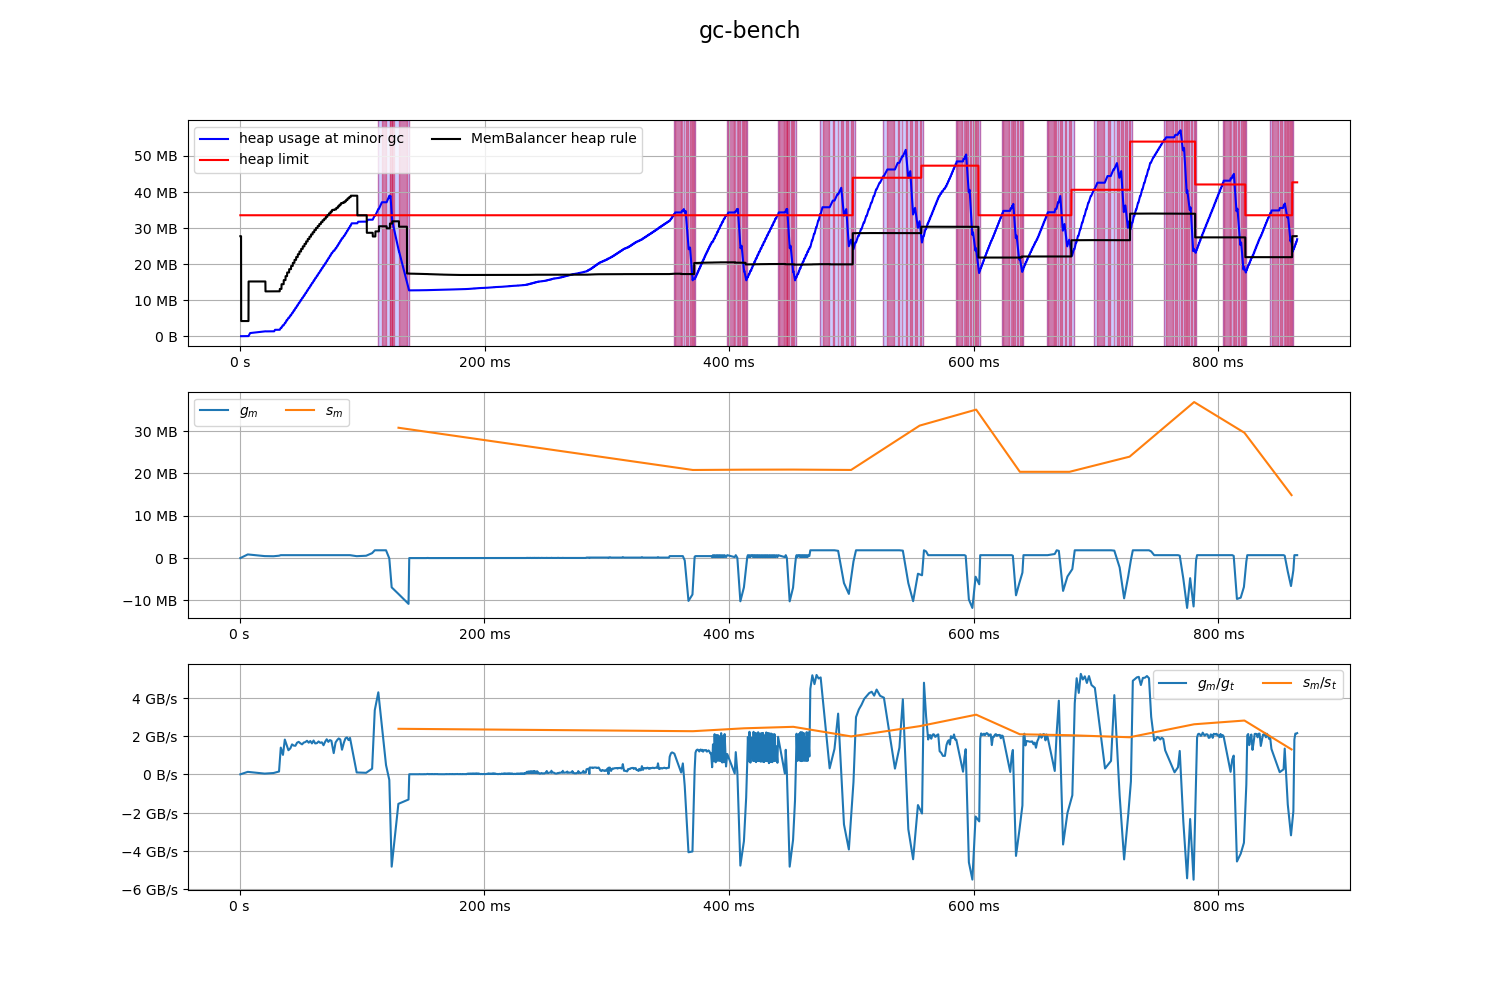

In [2]:
gcbench_events = get_events_from("logs/gcbench")
plot_gc(gcbench_events, "gc-bench", fignum=1)
mem_balancer = MemBalancer(TUNING=0.001)
mem_balancer.L_smoothed = 1024
mem_balancer.s_m_smoothed = 1
mem_balancer.s_t_smoothed = 1
plot_membalancer_heap_rule(gcbench_events, mem_balancer,fignum=1)

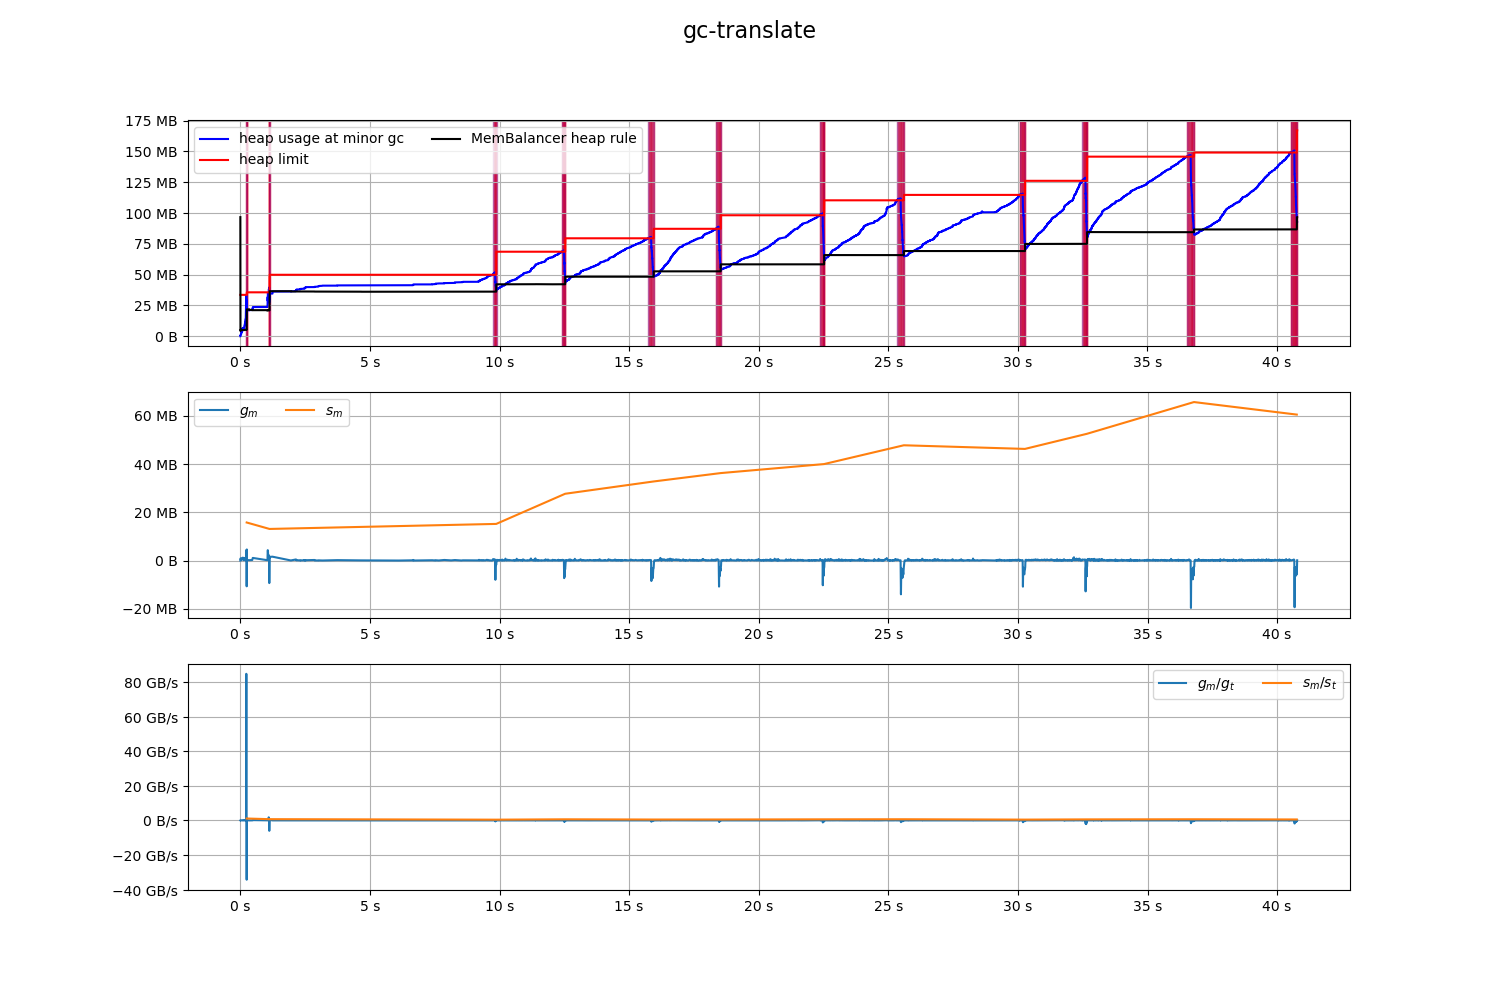

In [3]:
gctranslate_events = get_events_from("logs/gctranslate")
plot_gc(gctranslate_events, "gc-translate", fignum=2)
mem_balancer = MemBalancer(TUNING=0.0001)
mem_balancer.L_smoothed = 1
mem_balancer.s_m_smoothed = 1
mem_balancer.s_t_smoothed = 1
plot_membalancer_heap_rule(gctranslate_events, mem_balancer, fignum=2)